In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

file_path = '/content/drive/MyDrive/GoogleCollab/Clean_Dataset.csv'
df = pd.read_csv(file_path)

print("Jumlah data:", len(df))
print("\nContoh data:")
print(df.head())

label_cols = ['airline', 'flight', 'source_city', 'departure_time', 'stops',
              'arrival_time', 'destination_city', 'class']

le = LabelEncoder()
for col in label_cols:
    df[col] = le.fit_transform(df[col])

X = df.drop('price', axis=1)
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

start_time = time.time()
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
training_time = time.time() - start_time

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("\n=== HASIL EVALUASI MODEL ===")
print(f"Training time: {training_time:.2f} detik")
print(f"MAE (Mean Absolute Error): {mae:.2f}")
print(f"MSE (Mean Squared Error): {mse:.2f}")
print(f"RMSE (Root MSE): {rmse:.2f}")
print(f"R² Score: {r2:.4f}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Jumlah data: 300153

Contoh data:
   Unnamed: 0   airline   flight source_city departure_time stops  \
0           0  SpiceJet  SG-8709       Delhi        Evening  zero   
1           1  SpiceJet  SG-8157       Delhi  Early_Morning  zero   
2           2   AirAsia   I5-764       Delhi  Early_Morning  zero   
3           3   Vistara   UK-995       Delhi        Morning  zero   
4           4   Vistara   UK-963       Delhi        Morning  zero   

    arrival_time destination_city    class  duration  days_left  price  
0          Night           Mumbai  Economy      2.17          1   5953  
1        Morning           Mumbai  Economy      2.33          1   5953  
2  Early_Morning           Mumbai  Economy      2.17          1   5956  
3      Afternoon           Mumbai  Economy      2.25          1   5955  
4        Morning           Mumbai  Economy      2.33     

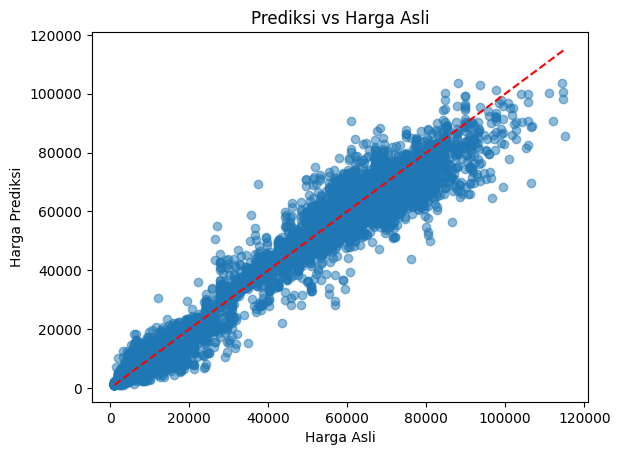

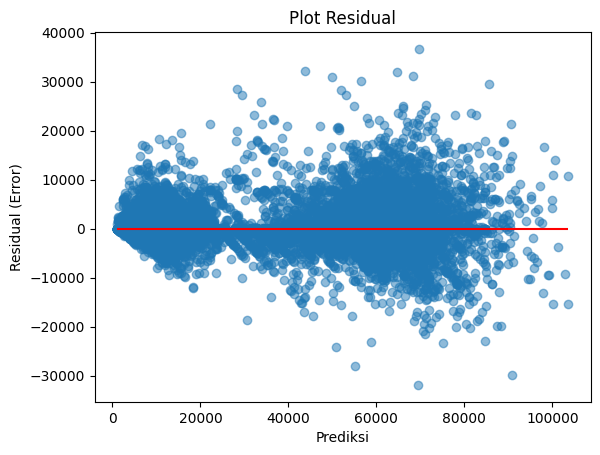

             Feature  Importance
0         Unnamed: 0    0.835174
8              class    0.061569
9           duration    0.047236
2             flight    0.026855
10         days_left    0.013812
7   destination_city    0.005733
3        source_city    0.002895
4     departure_time    0.002117
6       arrival_time    0.002014
5              stops    0.001533
1            airline    0.001062


In [ ]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Harga Asli')
plt.ylabel('Harga Prediksi')
plt.title('Prediksi vs Harga Asli')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')  # garis diagonal
plt.show()

residuals = y_test - y_pred
plt.scatter(y_pred, residuals, alpha=0.5)
plt.hlines(y=0, xmin=min(y_pred), xmax=max(y_pred), colors='r')
plt.xlabel('Prediksi')
plt.ylabel('Residual (Error)')
plt.title('Plot Residual')
plt.show()

importances = model.feature_importances_
features = X.columns
imp_df = pd.DataFrame({'Feature': features, 'Importance': importances})
imp_df = imp_df.sort_values(by='Importance', ascending=False)
print(imp_df)



In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("FlightPricePrediction") \
    .getOrCreate()


In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline
from pyspark.sql.functions import col

file_path = '/content/drive/MyDrive/GoogleCollab/Clean_Dataset.csv'

spark_df = spark.read.csv(file_path, inferSchema=True, header=True)

print("Jumlah data Spark DataFrame:", spark_df.count())
print("\nContoh data Spark DataFrame:")
spark_df.show(5)
spark_df.printSchema()

categorical_cols = ['airline', 'flight', 'source_city', 'departure_time',
                    'stops', 'arrival_time', 'destination_city', 'class']
numerical_cols = ['duration', 'days_left']

indexers = [StringIndexer(inputCol=col, outputCol=col + "_indexed", handleInvalid="keep") for col in categorical_cols]
encoders = [OneHotEncoder(inputCol=col + "_indexed", outputCol=col + "_vec") for col in categorical_cols]

feature_cols = [col + "_vec" for col in categorical_cols] + numerical_cols

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features", handleInvalid="keep")

dt = DecisionTreeRegressor(featuresCol="features", labelCol="price")

pipeline = Pipeline(stages=indexers + encoders + [assembler, dt])

(trainingData, testData) = spark_df.randomSplit([0.8, 0.2], seed=42)

pipeline_model = pipeline.fit(trainingData)

dt_predictions = pipeline_model.transform(testData)

print("\nContoh Prediksi:")
dt_predictions.select("price", "prediction", "features").show(5)

dt_evaluator = RegressionEvaluator(labelCol="price", predictionCol="prediction")

dt_rmse = dt_evaluator.evaluate(dt_predictions, {dt_evaluator.metricName: "rmse"})
dt_mae = dt_evaluator.evaluate(dt_predictions, {dt_evaluator.metricName: "mae"})
dt_r2 = dt_evaluator.evaluate(dt_predictions, {dt_evaluator.metricName: "r2"})

print("\n=== HASIL EVALUASI MODEL PySpark Decision Tree ===")
print("Decision Tree RMSE:", dt_rmse)
print("Decision Tree MAE:", dt_mae)
print("Decision Tree R2:", dt_r2)


Jumlah data Spark DataFrame: 300153

Contoh data Spark DataFrame:
+---+--------+-------+-----------+--------------+-----+-------------+----------------+-------+--------+---------+-----+
|_c0| airline| flight|source_city|departure_time|stops| arrival_time|destination_city|  class|duration|days_left|price|
+---+--------+-------+-----------+--------------+-----+-------------+----------------+-------+--------+---------+-----+
|  0|SpiceJet|SG-8709|      Delhi|       Evening| zero|        Night|          Mumbai|Economy|    2.17|        1| 5953|
|  1|SpiceJet|SG-8157|      Delhi| Early_Morning| zero|      Morning|          Mumbai|Economy|    2.33|        1| 5953|
|  2| AirAsia| I5-764|      Delhi| Early_Morning| zero|Early_Morning|          Mumbai|Economy|    2.17|        1| 5956|
|  3| Vistara| UK-995|      Delhi|       Morning| zero|    Afternoon|          Mumbai|Economy|    2.25|        1| 5955|
|  4| Vistara| UK-963|      Delhi|       Morning| zero|      Morning|          Mumbai|Economy|

In [ ]:
import pandas as pd
import numpy as np

manual_input = pd.DataFrame([{
    'airline': 'Vistara',
    'flight': 'UK-995',
    'source_city': 'Delhi',
    'departure_time': 'Morning',
    'stops': 'zero',
    'arrival_time': 'Afternoon',
    'destination_city': 'Mumbai',
    'class': 'Economy',
    'duration': 2.25,
    'days_left': 3
}])

manual_input_transformed = preprocessor.transform(manual_input)

predicted_price = model.predict(manual_input_transformed)

print(f"Prediksi harga tiket: ₹{predicted_price[0]:,.2f}")


NameError: name 'preprocessor' is not defined

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [ ]:
file_path = '/content/drive/MyDrive/GoogleCollab/Clean_Dataset.csv'
df = pd.read_csv(file_path)

print("Jumlah data:", len(df))
print("\nContoh data:")
print(df.head())

Jumlah data: 300153

Contoh data:
   Unnamed: 0   airline   flight source_city departure_time stops  \
0           0  SpiceJet  SG-8709       Delhi        Evening  zero   
1           1  SpiceJet  SG-8157       Delhi  Early_Morning  zero   
2           2   AirAsia   I5-764       Delhi  Early_Morning  zero   
3           3   Vistara   UK-995       Delhi        Morning  zero   
4           4   Vistara   UK-963       Delhi        Morning  zero   

    arrival_time destination_city    class  duration  days_left  price  
0          Night           Mumbai  Economy      2.17          1   5953  
1        Morning           Mumbai  Economy      2.33          1   5953  
2  Early_Morning           Mumbai  Economy      2.17          1   5956  
3      Afternoon           Mumbai  Economy      2.25          1   5955  
4        Morning           Mumbai  Economy      2.33          1   5955  
